In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# set randomseed for reproducibility
torch.manual_seed(42)

In [3]:
#check for GPU
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
df=pd.read_csv('/kaggle/input/fashion-mnist/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


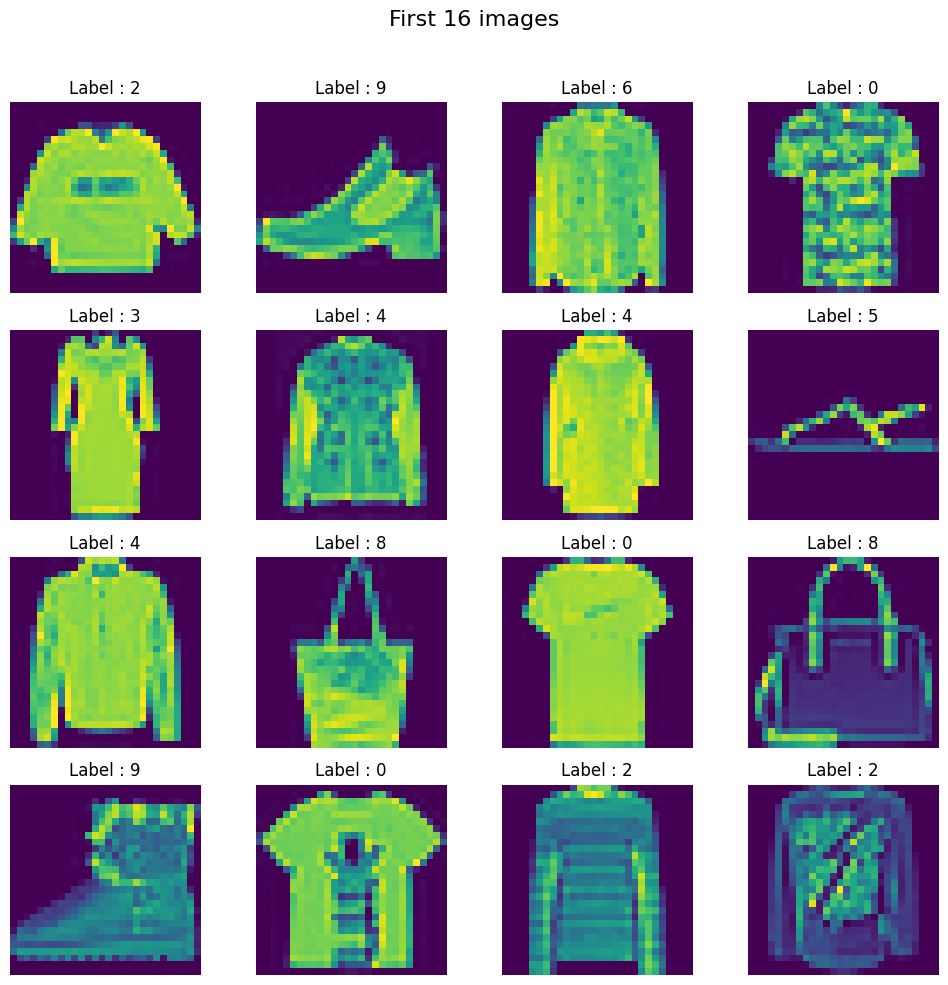

In [5]:
# Create a 4*4 grid of image
fig, axes= plt.subplots(4,4, figsize=(10,10))
fig.suptitle('First 16 images', fontsize=16)

# plot the first 16 images form dataset
for i, ax in enumerate(axes.flat):
    img=df.iloc[i,1:].values.reshape(28, 28) # reshape into 28*28
    ax.imshow(img)  # Display in Grayscal
    ax.axis('off')   # Remove axes for a cleaner look
    ax.set_title(f"Label : {df.iloc[i,0]}") # show the lable

plt.tight_layout(rect=[0,0,1,0.96]) # adjust layout to fit the title
plt.show()

In [6]:
# train test split
X=df.iloc[:, 1:]
y=df.iloc[:,0]
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

In [7]:
#  Image Transformations
from torchvision.transforms import transforms
custom_transoforms=transforms.Compose([
    transforms.Resize(228),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [8]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self,features,labels,transform):
        self.features=features.values
        self.labels=labels.values
        self.transform=transform
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self,index):
        # resize to (28,28)
        image=self.features[index].reshape(28,28)

        # cahnge dtatype(np.unit8)
        image=image.astype(np.uint8)

        # change 3 channel color image
        image=np.stack([image]*3,axis=-1)

        # Convert arr to PIL image
        image=Image.fromarray(image)

        # transofrmation call funtion
        image=self.transform(image)
        
        # return 
        return image, torch.tensor(self.labels[index] , dtype=torch.long)



In [9]:
train_dataset=CustomDataset(X_train,y_train,transform=custom_transoforms)
test_dataset=CustomDataset(X_test,y_test,transform=custom_transoforms)

In [10]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True, pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True, pin_memory=True)

In [11]:
# import the pretrained model
import torchvision.models as models
vgg16=models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 201MB/s] 


In [12]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [13]:
# freezing the vgg16.features parts
for param in vgg16.features.parameters():
    param.requires_grad=False

In [14]:
vgg16.classifier= nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,10),

)

In [15]:
vgg16=vgg16.to(device)

In [16]:
learning_rate=0.00001
epochs=2
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(vgg16.classifier.parameters(),lr=learning_rate)

In [17]:
for epoch in range(epochs):
    
    total_epoch_loss=0

    for batch_features, batch_labels in train_loader:
        
        batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)

        outputs=vgg16(batch_features)

        loss=criterion(outputs,batch_labels)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        

        total_epoch_loss= total_epoch_loss + loss.item()

        avg_loss=total_epoch_loss/len(train_loader)
        
        print(f'Epoch: {epoch+1}, Loss:{avg_loss}')


Epoch: 1, Loss:0.00154370911916097
Epoch: 1, Loss:0.0030739785830179852
Epoch: 1, Loss:0.0046016378402709964
Epoch: 1, Loss:0.006146009604136149
Epoch: 1, Loss:0.007670632521311442
Epoch: 1, Loss:0.009198968887329101
Epoch: 1, Loss:0.01073190434773763
Epoch: 1, Loss:0.012259563604990642
Epoch: 1, Loss:0.013789814472198486
Epoch: 1, Loss:0.015313405831654867
Epoch: 1, Loss:0.01681460173924764
Epoch: 1, Loss:0.018297125180562337
Epoch: 1, Loss:0.019790782610575357
Epoch: 1, Loss:0.021299907207489012
Epoch: 1, Loss:0.022774185180664062
Epoch: 1, Loss:0.024278414885203044
Epoch: 1, Loss:0.02575918213526408
Epoch: 1, Loss:0.027213845252990723
Epoch: 1, Loss:0.028702871163686118
Epoch: 1, Loss:0.030181693871816
Epoch: 1, Loss:0.03164234161376953
Epoch: 1, Loss:0.03310580237706502
Epoch: 1, Loss:0.034559805075327556
Epoch: 1, Loss:0.03600775829950968
Epoch: 1, Loss:0.03746163670221964
Epoch: 1, Loss:0.03890857966740926
Epoch: 1, Loss:0.04035504722595215
Epoch: 1, Loss:0.04178236214319865
Epoc

In [18]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9110833333333334


# **************CLIP ViT***************

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import clip


# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def classify_image(image_path):
    """Runs inference on a single image using CLIP."""
    # Load and preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Define class labels (modify as needed)
    class_labels = ["fake", "real"]

    # Tokenize text labels
    text_inputs = clip.tokenize(class_labels).to(device)

    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_inputs)

    # Compute similarity scores
    similarity = (image_features @ text_features.T).softmax(dim=-1)
    prediction = class_labels[similarity.argmax().item()]

    return prediction

if name == "main":
    image_path = "sample.jpg"  # Change to your test image
    result = classify_image(image_path)
    print(f"Prediction: {result}")

In [ ]:
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms

# Configuration (adjust paths as needed)
CHECKPOINT_PATH = "path/to/trained_classifier.pth"  # Trained linear layer weights
CLIP_MODEL = "ViT-B/32"  # Verify which CLIP variant was used in the repo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224  # Standard CLIP input size

class CLIPBasedDetector(torch.nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier = torch.nn.Linear(512, 1)  # CLIP ViT-B/32 has 512-dim features

    def forward(self, images):
        with torch.no_grad():  # CLIP features extraction
            image_features = self.clip.encode_image(images)
        return self.classifier(image_features)

def load_model(checkpoint_path=CHECKPOINT_PATH):
    # Load CLIP and create model structure
    clip_model, _ = clip.load(CLIP_MODEL, device=DEVICE, jit=False)
    model = CLIPBasedDetector(clip_model).to(DEVICE)

    # Load trained linear weights
    state_dict = torch.load(checkpoint_path, map_location=DEVICE)
    model.classifier.load_state_dict(state_dict)
    model.eval()
    return model

def preprocess_image(image_path):
    # Matching CLIP's preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                            (0.26862954, 0.26130258, 0.27577711))
    ])
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0).to(DEVICE)

def predict(image_path, model, threshold=0.5):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        logits = model(image_tensor)
    prob = torch.sigmoid(logits).item()
    return "Fake" if prob > threshold else "Real", prob

if __name__ == "__main__":
    # Example usage
    model = load_model()
    image_path = "path/to/test_image.jpg"
    prediction, confidence = predict(image_path, model)
    print(f"Prediction: {prediction} | Confidence: {confidence:.4f}")

In [ ]:
import torch
import clip
from torch.nn import Parameter
from torch.optim import Adam
from PIL import Image

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define learnable soft prompts
num_tokens = 5  # Number of learnable tokens
embedding_dim = model.token_embedding.weight.shape[1]  # Get CLIP embedding size (512 for ViT-B/32)

# Initialize learnable prompt embeddings
soft_prompt = Parameter(torch.randn(num_tokens, embedding_dim, device=device))

# Define class labels
class_labels = ["fake", "real"]
text_inputs = clip.tokenize(class_labels).to(device)

# Define optimizer to tune soft prompts
optimizer = Adam([soft_prompt], lr=0.01)

def train_soft_prompt(image_paths, labels, epochs=10):
    """Optimize the soft prompt using a small dataset."""
    for epoch in range(epochs):
        total_loss = 0
        for img_path, label in zip(image_paths, labels):
            # Load and preprocess image
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

            # Encode text with CLIP (frozen)
            with torch.no_grad():
                text_features = model.encode_text(text_inputs)

            # Encode image
            image_features = model.encode_image(image)

            # Normalize features
            text_features /= text_features.norm(dim=-1, keepdim=True)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # Compute similarity scores
            similarity = (image_features @ text_features.T).softmax(dim=-1)

            # Compute loss (cross-entropy)
            target = torch.tensor([class_labels.index(label)], dtype=torch.long, device=device)
            loss = torch.nn.functional.cross_entropy(similarity, target)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss / len(image_paths):.4f}")

def classify_image(image_path):
    """Runs inference on a single image using CLIP + soft prompt."""
    # Load and preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    # Encode text with CLIP (frozen)
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)

    # Encode image
    image_features = model.encode_image(image)

    # Normalize features
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    # Compute similarity scores
    similarity = (image_features @ text_features.T).softmax(dim=-1)
    prediction = class_labels[similarity.argmax().item()]

    return prediction

# Example usage
if __name__ == "__main__":
    # Train soft prompt on a small dataset (fake vs. real images)
    train_soft_prompt(["fake1.jpg", "real1.jpg"], ["fake", "real"], epochs=5)

    # Test on an image
    test_image = "sample.jpg"
    result = classify_image(test_image)
    print(f"Prediction: {result}")


In [ ]:
import torch
import clip
from PIL import Image

def load_clip_model(device="cuda" if torch.cuda.is_available() else "cpu"):
    model, preprocess = clip.load("ViT-B/32", device=device)
    return model, preprocess, device

def classify_fake_vs_real(image_path, model, preprocess, device):
    # Load and preprocess the image
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    # Define text labels for classification
    text_labels = ["Real", "Fake"]
    text = clip.tokenize(text_labels).to(device)
    
    # Compute image and text features
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
    
    # Normalize features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    # Compute cosine similarity between image and text labels
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    # Get top match
    values, indices = similarity[0].topk(2)
    
    # Print results
    results = [(text_labels[idx], values[i].item()) for i, idx in enumerate(indices)]
    return results

if __name__ == "__main__":
    model, preprocess, device = load_clip_model()
    image_path = "path_to_image.jpg"  # Change this to your image path
    results = classify_fake_vs_real(image_path, model, preprocess, device)
    
    print("Inference Results:")
    for label, score in results:
        print(f"{label}: {score:.4f}")
